<div class="alert alert-block alert-warning"  style="background-color: #c78cf5; color: black;">  
  <h1>Image Generation via β-VAE</h1>
</div>

---

Here is the data for this project: [CelebA dataest](https://www.kaggle.com/datasets/therealcyberlord/50k-celeba-dataset-64x64)

<div class="alert alert-block alert-warning"  style="background-color: #c78cf5; color: black;">  
  <h1>Imports</h1>
</div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from abc import ABC, abstractmethod
from typing import List
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Subset, random_split

import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchvision.utils as vutils

TEST_CODE = False

<div class="alert alert-block alert-warning"  style="background-color: #c78cf5; color: black;">  
  <h1>Introduction</h1>
</div>

In this project, I explore the **Beta-VAE model**, a variant of the standard **Variational Autoencoder (VAE)**, using the CelebA dataset. The goal is to train a Beta-VAE model and explore how different beta values affect model performance. 

First, I think it's helpful to explain the  **Autoencoder (AE)**, **Variational Autoencoder (VAE)**, and finally **Beta-VAE**. 

$\underline{\text{Autoencoder (AE)}}$

An Autoencoder compresses data into a latent (i.e. lower-dimensional) representation and then reconstruct it back to its original form. There are two pieces: an **encoder** and a **decoder**. The former compresses the input into a latent space, and the latter reconstructs the input from the latent space. An autoencoder is **deterministic**. 

$\underline{\text{Variational Autoencoder (VAE)}}$

Like the Autoencoder, a **Variational Autoencoder (VAE)** compresses data. However, VAEs extend beyond AEs in that they *map it to a probability distribution* (often a Gaussian distribution). Then, the decoder samples from the probability distribution to reconstruct the input. Therefore, a VAE is **probabilistic** and a form of generative AI. 

Total Loss = Reconstruction Loss + KL Divergence Loss

**KL Divergence Loss** ensures that:
* The latent space is smooth and continuous.
* We can generate new images by sampling random points.
* Similar images are mapped to nearby points in latent space.

$\underline{\text{Beta-VAE}}$ 

A **Beta-VAE** introduces a weighting factor, β, on the KL divergence term in the loss function. A higher beta encourages the model to learn more independent and interpretable latent factors. Beta-VAE uses this loss function:

Total Loss = Reconstruction Loss + β × KL Divergence Loss

β (beta) acts like a control for how much we care about having a well-structured latent space. Note that β=1 is a standard VAE. 

<div class="alert alert-block alert-warning"  style="background-color: #c78cf5; color: black;">  
  <h1>Data Preparation</h1>
</div>

# Load and Transform Data

In [ ]:
image_size = 64
dataset_path = "data"
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
    ])
dataset = ImageFolder(root=dataset_path, transform=transform) # load dataset using torchvision's ImageFolder

# Split Into Training and Testing

In [3]:
# Use subset if just testing code 
if TEST_CODE == True:
    subset_indices = list(range(20))
    small_dataset = Subset(dataset, subset_indices)

    train_size = int(0.8 * len(small_dataset))
    test_size = len(small_dataset) - train_size
    train_subset, test_subset = random_split(small_dataset, [train_size, test_size])

    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

# Use full dataset when code is ready
else: 
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# View Samples

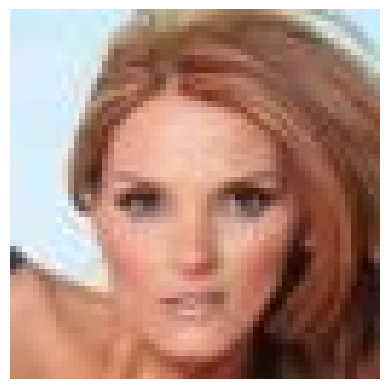

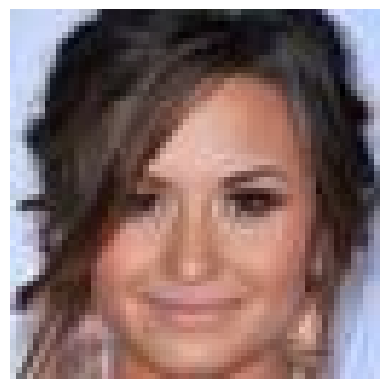

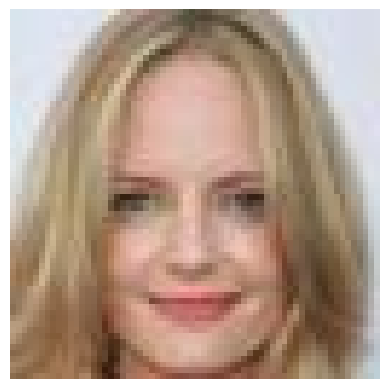

In [4]:
def view_image(tensor_image):
    """
    Display a single image tensor (C x H x W) from the DataLoader.

    Parameters
    ----------
        - tensor_image (torch.Tensor): A single image tensor.

    Returns
    -------
        - None, displays the image.
    """
    # Convert tensor to NumPy format and transpose dimensions to (H x W x C)
    image_np = tensor_image.permute(1, 2, 0).cpu().numpy()
    
    # Display the image 
    plt.imshow(image_np)
    plt.axis('off')
    plt.show()

images, _ = next(iter(train_loader))
for i in range(3):
    view_image(images[i])

<div class="alert alert-block alert-warning"  style="background-color: #c78cf5; color: black;">  
  <h1>Training</h1>
</div>

# Beta-VAE Classes

In [5]:
class BaseVAE(nn.Module, ABC):
    """
    Abstract base class for Variational Autoencoders.

    Defines the required structure and functionality that any subclass (e.g., BetaVAE)
    must implement to be used as a VAE.

    Methods
    -------
        - encode(input): Encodes input into latent space parameters.
        - decode(input): Decodes latent vectors into image space.
        - sample(batch_size, current_device, **kwargs): Samples from latent space.
        - generate(x, **kwargs): Reconstructs input from the latent space.
        - forward(*inputs): Full forward pass through the model.
        - loss_function(*inputs, **kwargs): Computes the VAE loss.
    """
    def __init__(self) -> None:
        """
        Initialize the base VAE class.

        Parameters
        ----------
            - None

        Returns
        -------
            - None
        """
        super(BaseVAE, self).__init__()

    def encode(self, input):
        """
        Encode input tensor into latent space parameters.

        Parameters
        ----------
            - input (torch.Tensor): Input tensor (e.g., image batch).

        Returns
        -------
            - tuple of torch.Tensor: Mean and log-variance of latent distribution.
        """
        raise NotImplementedError

    def decode(self, input):
        """
        Decode latent vector back into image space.

        Parameters
        ----------
            - input (torch.Tensor): Latent vector sampled from the distribution.

        Returns
        -------
            - torch.Tensor: Reconstructed image tensor.
        """
        raise NotImplementedError

    def sample(self, batch_size: int, current_device, **kwargs):
        """
        Sample from the latent space and decode to image space.

        Parameters
        ----------
            - batch_size (int): Number of samples to generate.
            - current_device (torch.device): Device for computation (CPU or CUDA).
            - **kwargs: Optional additional arguments.

        Returns
        -------
            - torch.Tensor: Generated image samples.
        """
        raise NotImplementedError

    def generate(self, x, **kwargs):
        """
        Generate reconstructed output for a given input image.

        Parameters
        ----------
            - x (torch.Tensor): Input tensor (e.g., image batch).
            - **kwargs: Optional additional arguments.

        Returns
        -------
            - torch.Tensor: Reconstructed image tensor.
        """
        raise NotImplementedError

    @abstractmethod
    def forward(self, *inputs):
        """
        Forward pass through the encoder, sampling, and decoder.

        Parameters
        ----------
            - *inputs: Input tensors (typically a single image tensor).

        Returns
        -------
            - list of torch.Tensor: Reconstructed image, original input, mean, and log-variance.
        """
        pass

    @abstractmethod
    def loss_function(self, *inputs, **kwargs):
        """
        Compute the loss for VAE training.

        Parameters
        ----------
            - *inputs: Tensors output by the model (recons, input, mu, log_var).
            - **kwargs: Additional arguments such as batch weighting (e.g., M_N).

        Returns
        -------
            - dict: Dictionary containing total loss, reconstruction loss, and KL divergence.
        """
        pass


class BetaVAE(BaseVAE):
    """
    Beta-VAE implementation with configurable beta, gamma, and capacity control.

    Parameters
    ----------
        - in_channels (int): Number of input channels (e.g., 3 for RGB).
        - latent_dim (int): Dimensionality of latent space.
        - hidden_dims (List, optional): List of convolutional feature sizes. Defaults to [32, 64, 128, 256, 512].
        - beta (int): Weight of KL divergence term in the loss. Defaults to 4.
        - gamma (float): Capacity loss weight for 'B'-type loss. Defaults to 1000.
        - max_capacity (int): Maximum capacity for KL term (only for 'B'-type loss). Defaults to 25.
        - Capacity_max_iter (int): Iterations to reach max capacity. Defaults to 1e5.
        - loss_type (str): Either 'H' (Higgins) or 'B' (Burgess). Defaults to 'B'.
    """
    num_iter = 0  # Global static variable to keep track of iterations

    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims: List = None,
                 beta: int = 4,
                 gamma: float = 1000.,
                 max_capacity: int = 25,
                 Capacity_max_iter: int = 1e5,
                 loss_type: str = 'B',
                 **kwargs) -> None:
        super(BetaVAE, self).__init__()

        self.latent_dim = latent_dim
        self.beta = beta
        self.gamma = gamma
        self.loss_type = loss_type
        self.C_max = torch.Tensor([max_capacity])
        self.C_stop_iter = Capacity_max_iter

        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder - More aggressive downsampling for cleaner latent space
        encoder_modules = []

        # First conv block: 28x28 -> 14x14
        encoder_modules.append(
            nn.Sequential(
                nn.Conv2d(in_channels, 32, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True)
            )
        )

        # Second conv block: 14x14 -> 7x7
        encoder_modules.append(
            nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True)
            )
        )

        # Third conv block: 7x7 -> 4x4 (using padding=2 to handle odd dimension)
        encoder_modules.append(
            nn.Sequential(
                nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=2),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True)
            )
        )

        # Fourth conv block: 4x4 -> 2x2
        encoder_modules.append(
            nn.Sequential(
                nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True)
            )
        )

        self.encoder = nn.Sequential(*encoder_modules)

        # Latent space projections
        self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_var = nn.Linear(256 * 4 * 4, latent_dim)


        # Build Decoder
        self.decoder_input = nn.Linear(latent_dim, 256 * 4 * 4)

        decoder_modules = []

        # First deconv: 2x2 -> 4x4
        decoder_modules.append(
            nn.Sequential(
                nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True)
            )
        )

        # Second deconv: 4x4 -> 7x7 (needs careful handling)
        decoder_modules.append(
            nn.Sequential(
                nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=2, output_padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True)
            )
        )

        # Third deconv: 7x7 -> 14x14
        decoder_modules.append(
            nn.Sequential(
                nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True)
            )
        )
        
        self.decoder = nn.Sequential(
            # 4x4 → 8x8
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            # 8x8 → 16x16
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            # 16x16 → 32x32
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            # 32x32 → 64x64
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
        )

        self.final_layer = nn.Sequential(
            nn.Conv2d(16, 3, kernel_size=3, padding=1),  # final RGB output
            nn.Sigmoid()
        )


    def encode(self, input):
        """
        Encode input tensor into latent distribution parameters.

        Parameters
        ----------
            - input (torch.Tensor): Input image tensor of shape (B, C, H, W).

        Returns
        -------
            - List[torch.Tensor]: Mean and log-variance of latent Gaussian distribution.
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z):
        """
        Decode latent vector into reconstructed image.

        Parameters
        ----------
            - z (torch.Tensor): Latent tensor of shape (B, latent_dim).

        Returns
        -------
            - torch.Tensor: Reconstructed image tensor of shape (B, C, H, W).
        """
        result = self.decoder_input(z)
        result = result.view(-1, 256, 4, 4)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu, logvar):
        """
        Apply reparameterization trick to sample from latent distribution.

        Parameters
        ----------
            - mu (torch.Tensor): Mean of latent distribution.
            - logvar (torch.Tensor): Log-variance of latent distribution.

        Returns
        -------
            - torch.Tensor: Sampled latent vector.
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input, **kwargs):
        """
        Perform full forward pass through encoder, sampling, and decoder.

        Parameters
        ----------
            - input (torch.Tensor): Input image tensor.

        Returns
        -------
            - List[torch.Tensor]: Reconstructed image, original input, mu, and log_var.
        """
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return [self.decode(z), input, mu, log_var]

    def loss_function(self, *args, **kwargs):
        """
        Compute VAE loss, including reconstruction and KL divergence terms.

        Parameters
        ----------
            - *args: Should include reconstructed image, input image, mu, and log_var.
            - **kwargs:
                - M_N (float): Minibatch weight = batch_size / dataset_size.

        Returns
        -------
            - dict: Dictionary containing total loss, reconstruction loss, and KL divergence.
        """
        self.num_iter += 1
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]
        kld_weight = kwargs['M_N']  # Account for the minibatch samples from the dataset

        # Use binary cross entropy for better Fashion-MNIST results
        recons_loss = F.binary_cross_entropy(recons, input, reduction='sum') / input.size(0)
        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim=1), dim=0)

        if self.loss_type == 'H':  # https://openreview.net/forum?id=Sy2fzU9gl
            loss = recons_loss + self.beta * kld_weight * kld_loss
        elif self.loss_type == 'B':  # https://arxiv.org/pdf/1804.03599.pdf
            self.C_max = self.C_max.to(input.device)
            C = torch.clamp(self.C_max / self.C_stop_iter * self.num_iter, 0, self.C_max.data[0])
            loss = recons_loss + self.gamma * kld_weight * (kld_loss - C).abs()
        else:
            raise ValueError('Undefined loss type.')

        return {'loss': loss, 'Reconstruction_Loss': recons_loss, 'KLD': kld_loss}

    def sample(self, num_samples: int, current_device, **kwargs):
        """
        Sample from the latent space and decode to image space.

        Parameters
        ----------
            - num_samples (int): Number of images to generate.
            - current_device (torch.device): Device to perform computations on.
            - **kwargs: Optional additional arguments.

        Returns
        -------
            - torch.Tensor: Generated image tensor of shape (num_samples, C, H, W).
        """
        z = torch.randn(num_samples, self.latent_dim)
        z = z.to(current_device)
        samples = self.decode(z)
        return samples

    def generate(self, x, **kwargs):
        """
        Reconstruct an image batch given the input batch.

        Parameters
        ----------
            - x (torch.Tensor): Input image batch tensor.
            - **kwargs: Optional additional arguments.

        Returns
        -------
            - torch.Tensor: Reconstructed image tensor.
        """
        return self.forward(x)[0]
   

# Functions for Training and Testing

In [6]:
def train_beta_vae(model, train_loader, optimizer, device, epoch):
    """
    Train the Beta-VAE model for one epoch.

    Parameters
    ----------
        - model (nn.Module): The Beta-VAE model to train.
        - train_loader (DataLoader): DataLoader for the training dataset.
        - optimizer (torch.optim.Optimizer): Optimizer used to update model weights.
        - device (torch.device): Device to run training on (CPU or CUDA).
        - epoch (int): Current epoch number (used for logging).

    Returns
    -------
        - avg_loss (float): Average total loss over the epoch.
        - avg_recon_loss (float): Average reconstruction loss over the epoch.
        - avg_kld_loss (float): Average KL divergence loss over the epoch.
    """
    model.train()
    train_loss = 0
    train_recon_loss = 0
    train_kld_loss = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        # Forward pass
        results = model(data)

        # Calculate loss with proper dataset weighting
        loss_dict = model.loss_function(*results, M_N=len(data)/len(train_loader.dataset))
        loss = loss_dict['loss']

        # Backward pass
        loss.backward()
        optimizer.step()

        # Accumulate losses
        train_loss += loss.item()
        train_recon_loss += loss_dict['Reconstruction_Loss'].item()
        train_kld_loss += loss_dict['KLD'].item()

        if batch_idx % 200 == 0:
            print(f'Training Epoch {epoch}\n----------------\n[{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\t'
                  f'Loss: {loss.item():.4f}')

    avg_loss = train_loss / len(train_loader)
    avg_recon_loss = train_recon_loss / len(train_loader)
    avg_kld_loss = train_kld_loss / len(train_loader)

    print(f'Average loss: {avg_loss:.4f}, '
          f'Recon Loss: {avg_recon_loss:.4f}, KLD Loss: {avg_kld_loss:.4f}\n')

    return avg_loss, avg_recon_loss, avg_kld_loss


def test_beta_vae(model, test_loader, device):
    """
    Evaluate the Beta-VAE model on the test dataset.

    Parameters
    ----------
        - model (nn.Module): The trained Beta-VAE model.
        - test_loader (DataLoader): DataLoader for the test dataset.
        - device (torch.device): Device to run evaluation on (CPU or CUDA).

    Returns
    -------
        - test_loss (float): Average total loss over the test set.
    """
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            results = model(data)
            loss_dict = model.loss_function(*results, M_N=len(data)/len(test_loader.dataset))
            test_loss += loss_dict['loss'].item()

    test_loss /= len(test_loader)
    print(f'Test set loss: {test_loss:.4f}')
    return test_loss


In [7]:
def visualize_reconstructions(model, test_loader, device, num_images=8):
    """
    Visualize original vs. reconstructed images from the Beta-VAE.

    Parameters
    ----------
        - model (nn.Module): Trained Beta-VAE model.
        - test_loader (DataLoader): DataLoader for the test dataset.
        - device (torch.device): Device to run evaluation on.
        - num_images (int): Number of images to visualize. Default is 8.

    Returns
    -------
        - None, displays a matplotlib figure comparing original and reconstructed images.
    """
    model.eval()

    with torch.no_grad():
        data, _ = next(iter(test_loader))
        data = data[:num_images].to(device)
        reconstructions = model.generate(data)

        # Move to CPU and convert to numpy
        data = data.cpu().numpy()
        reconstructions = reconstructions.cpu().numpy()

        fig, axes = plt.subplots(2, num_images, figsize=(15, 4))

        for i in range(num_images):
            # Original images
            axes[0, i].imshow(np.transpose(data[i], (1, 2, 0)))
            axes[1, i].imshow(np.transpose(reconstructions[i], (1, 2, 0)))

            axes[0, i].set_title('Original')
            axes[0, i].axis('off')

            # Reconstructed images
            axes[1, i].set_title('Reconstructed')
            axes[1, i].axis('off')

        plt.tight_layout()
        plt.show()


def generate_latent_space_visualization(model, device, latent_dim=2):
    """
    Generate and visualize images sampled from a 2D latent space grid.

    Parameters
    ----------
        - model (nn.Module): Trained Beta-VAE model.
        - device (torch.device): Device to run decoding on.
        - latent_dim (int): Dimensionality of the latent space (must be 2 for this function).

    Returns
    -------
        - None, displays a grid of generated images from the latent space.
    """
    if latent_dim != 2:
        print("Warning: This visualization is designed for 2D latent space.")
        return

    model.eval()

    # Generate images in the 2D latent space
    with torch.no_grad():
        # Define the grid in the 2D latent space
        n_samples_per_class = 12
        x_values = torch.linspace(-3, 3, n_samples_per_class)
        y_values = torch.linspace(-3, 3, n_samples_per_class)
        grid_x, grid_y = torch.meshgrid(x_values, y_values, indexing='ij')
        z_grid = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=1).to(device)

        # Decode the grid points to generate images
        generated_images = model.decode(z_grid).cpu().numpy()

        # Visualize the generated images in the 2D latent space
        plt.figure(figsize=(15, 15))

        for i in range(generated_images.shape[0]):
            image = generated_images[i].squeeze()
            ax = plt.subplot(n_samples_per_class, n_samples_per_class, i + 1)
            ax.imshow(np.transpose(image, (1, 2, 0)))
            ax.axis('off')

        plt.suptitle("Beta-VAE - Generated Images in 2D Latent Space", fontsize=16)
        plt.tight_layout()
        plt.show()


def test_model_dimensions():
    """
    Test function to verify that the Beta-VAE model produces expected output dimensions.

    Returns
    -------
        - bool: True if output shapes match input shape, else False. Prints shape diagnostics.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Create a test model
    model = BetaVAE(
        in_channels=3,
        latent_dim=2,
        beta=1,
        loss_type='H'
    ).to(device)

    # Test with a batch of CelebA sized images
    test_input = torch.randn(4, 3, 64, 64).to(device)

    with torch.no_grad():
        # Test encoder
        mu, log_var = model.encode(test_input)
        print(f"Input shape: {test_input.shape}")
        print(f"Encoded mu shape: {mu.shape}")
        print(f"Encoded log_var shape: {log_var.shape}")

        # Test reparameterization
        z = model.reparameterize(mu, log_var)
        print(f"Latent z shape: {z.shape}")

        # Test decoder
        decoded = model.decode(z)
        print(f"Decoded shape: {decoded.shape}")

        # Test full forward pass
        output = model(test_input)
        reconstruction = output[0]
        print(f"Reconstruction shape: {reconstruction.shape}")

        if reconstruction.shape == test_input.shape:
            print("✅ Model dimensions are correct!")
            return True
        else:
            print("❌ Model dimensions are incorrect!")
            return False

def compare_beta_values():
    """
    Train and compare Beta-VAE models with different beta values.

    Returns
    -------
        - trained_models (dict): Dictionary containing model, training losses,
                                 reconstruction losses, KL divergence losses, and test loss for each beta.
        - test_loader (DataLoader): DataLoader used for evaluation.
        - device (torch.device): Device used for computation (CPU or CUDA).
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load data
    global train_loader 
    global test_loader

    # Different beta values to compare
    beta_values = [1, 4, 10]
    trained_models = {}

    for beta in beta_values:
        print("-----------------------------------------------------------------------------------------------")
        print(f"Training Beta-VAE with beta = {beta}")
        print("-----------------------------------------------------------------------------------------------")

        # Reset the global iteration counter for each model
        BetaVAE.num_iter = 0

        # Create model
        model = BetaVAE(
            in_channels=3,
            latent_dim=2,  # Using 2D latent space for visualization
            beta=beta,
            loss_type='H'
        ).to(device)

        # Optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

        # Training loop
        num_epochs = 10
        train_losses = []
        recon_losses = []
        kld_losses = []

        for epoch in range(1, num_epochs + 1):
            train_loss, recon_loss, kld_loss = train_beta_vae(
                model, train_loader, optimizer, device, epoch)
            train_losses.append(train_loss)
            recon_losses.append(recon_loss)
            kld_losses.append(kld_loss)

        # Test the model
        test_loss = test_beta_vae(model, test_loader, device)

        # Store everything
        trained_models[beta] = {
            'model': model,
            'train_losses': train_losses,
            'recon_losses': recon_losses,
            'kld_losses': kld_losses,
            'test_loss': test_loss
        }

        print(f"Final test loss for beta={beta}: {test_loss:.4f}")

    return trained_models, test_loader, device


# Train

In [8]:
trained_models, test_loader, device = compare_beta_values()

Using device: cpu
-----------------------------------------------------------------------------------------------
Training Beta-VAE with beta = 1
-----------------------------------------------------------------------------------------------
Training Epoch 1
----------------
[0/40000 (0%)]	Loss: 8714.4854
Training Epoch 1
----------------
[12800/40000 (32%)]	Loss: 7400.9810
Training Epoch 1
----------------
[25600/40000 (64%)]	Loss: 7310.5615
Training Epoch 1
----------------
[38400/40000 (96%)]	Loss: 7240.5181
Average loss: 7385.3153, Recon Loss: 7385.0081, KLD Loss: 191.9674

Training Epoch 2
----------------
[0/40000 (0%)]	Loss: 7162.3159
Training Epoch 2
----------------
[12800/40000 (32%)]	Loss: 7315.5225
Training Epoch 2
----------------
[25600/40000 (64%)]	Loss: 7187.2178
Training Epoch 2
----------------
[38400/40000 (96%)]	Loss: 7346.6045
Average loss: 7319.6180, Recon Loss: 7319.2364, KLD Loss: 238.5207

Training Epoch 3
----------------
[0/40000 (0%)]	Loss: 7448.7612
Trainin

<div class="alert alert-block alert-warning"  style="background-color: #c78cf5; color: black;">  
  <h1>Results Analysis</h1>
</div>

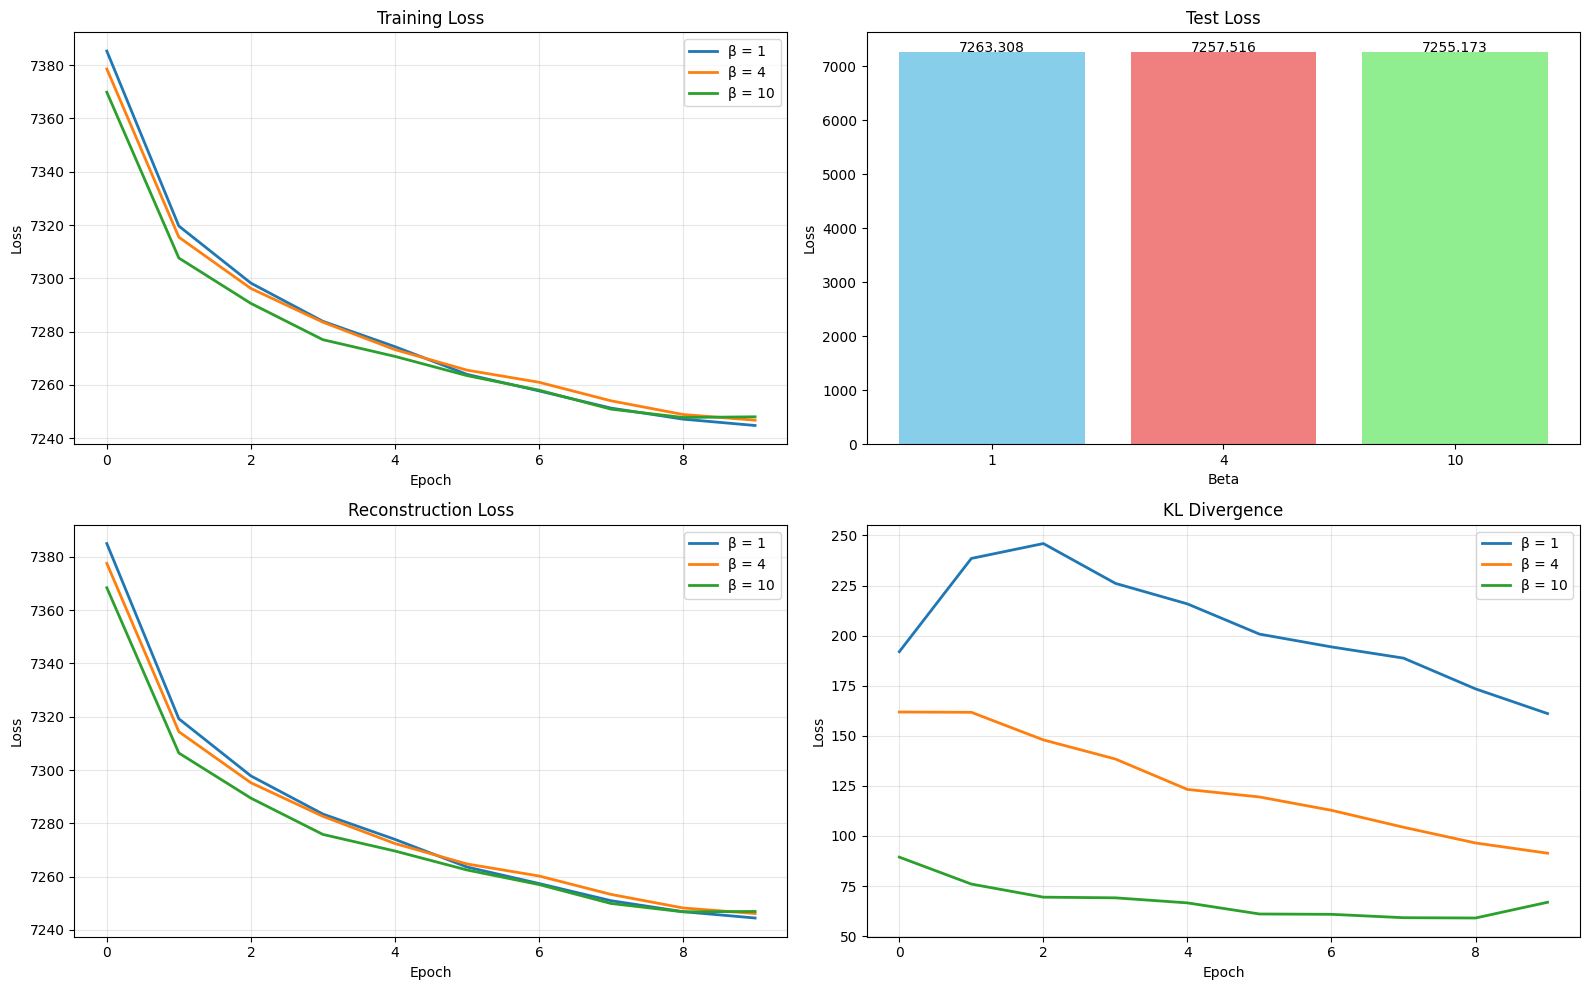

In [9]:
def plot_beta_losses(trained_models):
    """
    Plot training, test, reconstruction, and KL divergence losses for each beta.

    Parameters
    ----------
        - trained_models (dict): Dictionary of trained models keyed by beta value.

    Returns
    -------
        - None, displays 2x2 grid of loss plots.
    """
    betas = list(trained_models.keys())

    fig, axs = plt.subplots(2, 2, figsize=(16, 10))

    # Training Loss
    for beta in betas:
        axs[0, 0].plot(trained_models[beta]['train_losses'], label=f'β = {beta}', linewidth=2)
    axs[0, 0].set_title('Training Loss')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()
    axs[0, 0].grid(True, alpha=0.3)

    # Test Loss
    test_losses = [trained_models[beta]['test_loss'] for beta in betas]
    axs[0, 1].bar([str(beta) for beta in betas], test_losses, color=['skyblue', 'lightcoral', 'lightgreen'])
    axs[0, 1].set_title('Test Loss')
    axs[0, 1].set_xlabel('Beta')
    axs[0, 1].set_ylabel('Loss')
    for i, loss in enumerate(test_losses):
        axs[0, 1].text(i, loss + 0.01, f'{loss:.3f}', ha='center')

    # Recon Loss
    for beta in betas:
        axs[1, 0].plot(trained_models[beta]['recon_losses'], label=f'β = {beta}', linewidth=2)
    axs[1, 0].set_title('Reconstruction Loss')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].set_ylabel('Loss')
    axs[1, 0].legend()
    axs[1, 0].grid(True, alpha=0.3)

    # KL Divergence
    for beta in betas:
        axs[1, 1].plot(trained_models[beta]['kld_losses'], label=f'β = {beta}', linewidth=2)
    axs[1, 1].set_title('KL Divergence')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].set_ylabel('Loss')
    axs[1, 1].legend()
    axs[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    
plot_beta_losses(trained_models)

* *Top left*: All β values show decreasing loss across epochs, as I expected. β = 10 slightly outperforms the others for most of the epochs, suggesting that stronger regularization leads to smoother convergence. β = 1 has the best training loss by the end. 
* *Top right*: β = 10 yields the lowest test loss, β = 4 is close behind, and β = 1 performs worst, although the difference is small. 
* *Bottom left*: All three models decrease steadily. β = 1 maintains the highest recon loss, and β = 10 has the lowest. 
* *Bottom right*: β = 1 shows very high KL divergence at first, then drops slowly. β = 10 keeps KL divergence very low. β = 4 stays in between. β = 1 is vanilla VAE. 

Overall, β = 10 gives you the most disentangled latent space (lowest KL), best test loss, and best recon loss. β = 4 is a solid middle ground. β = 1 is less regularized, higher KL divergence, slightly worse performance.

<div class="alert alert-block alert-warning"  style="background-color: #c78cf5; color: black;">  
  <h1>Experimentation</h1>
</div>

-----------------------------------------------------------------------------------------------
Comparing Reconstructions for Different Beta Values:
-----------------------------------------------------------------------------------------------

Beta = 1


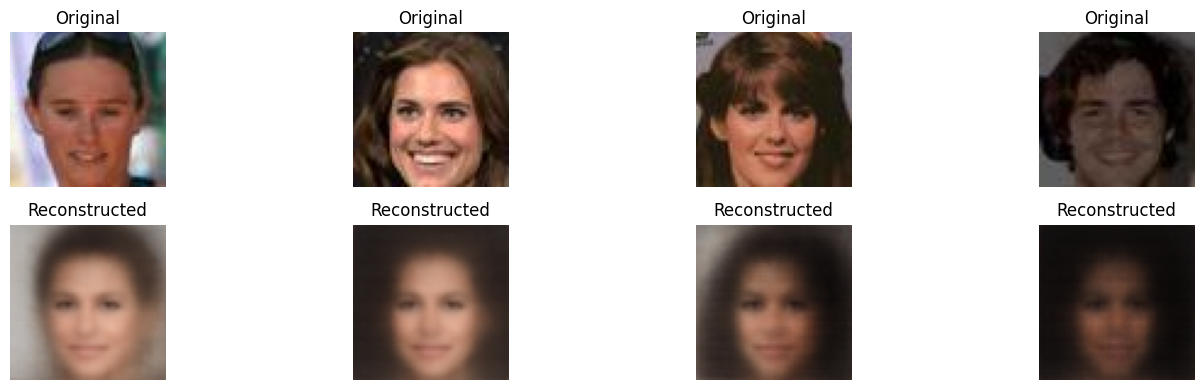


Beta = 4


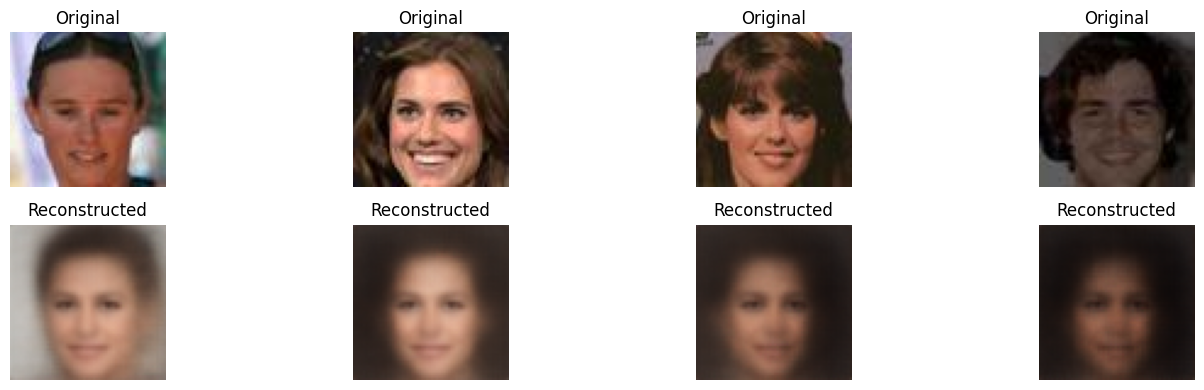


Beta = 10


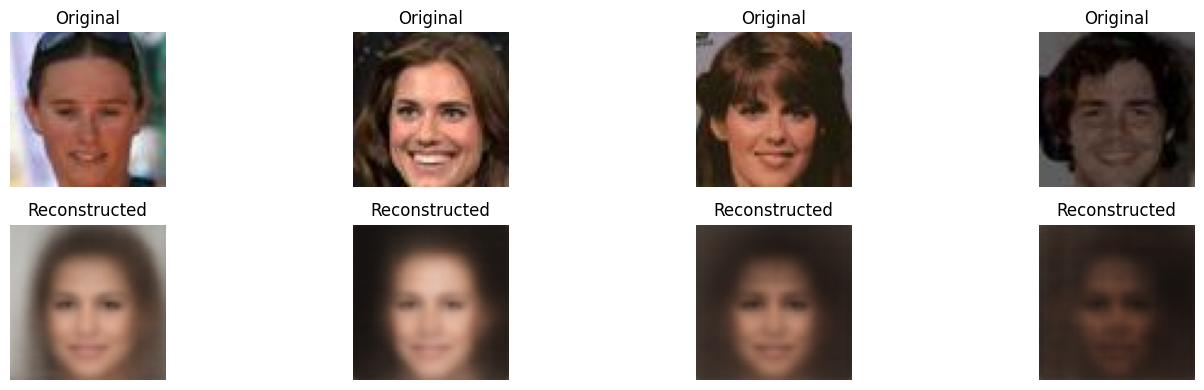

-----------------------------------------------------------------------------------------------
Comparing Latent Space Visualizations:
-----------------------------------------------------------------------------------------------

Beta = 1


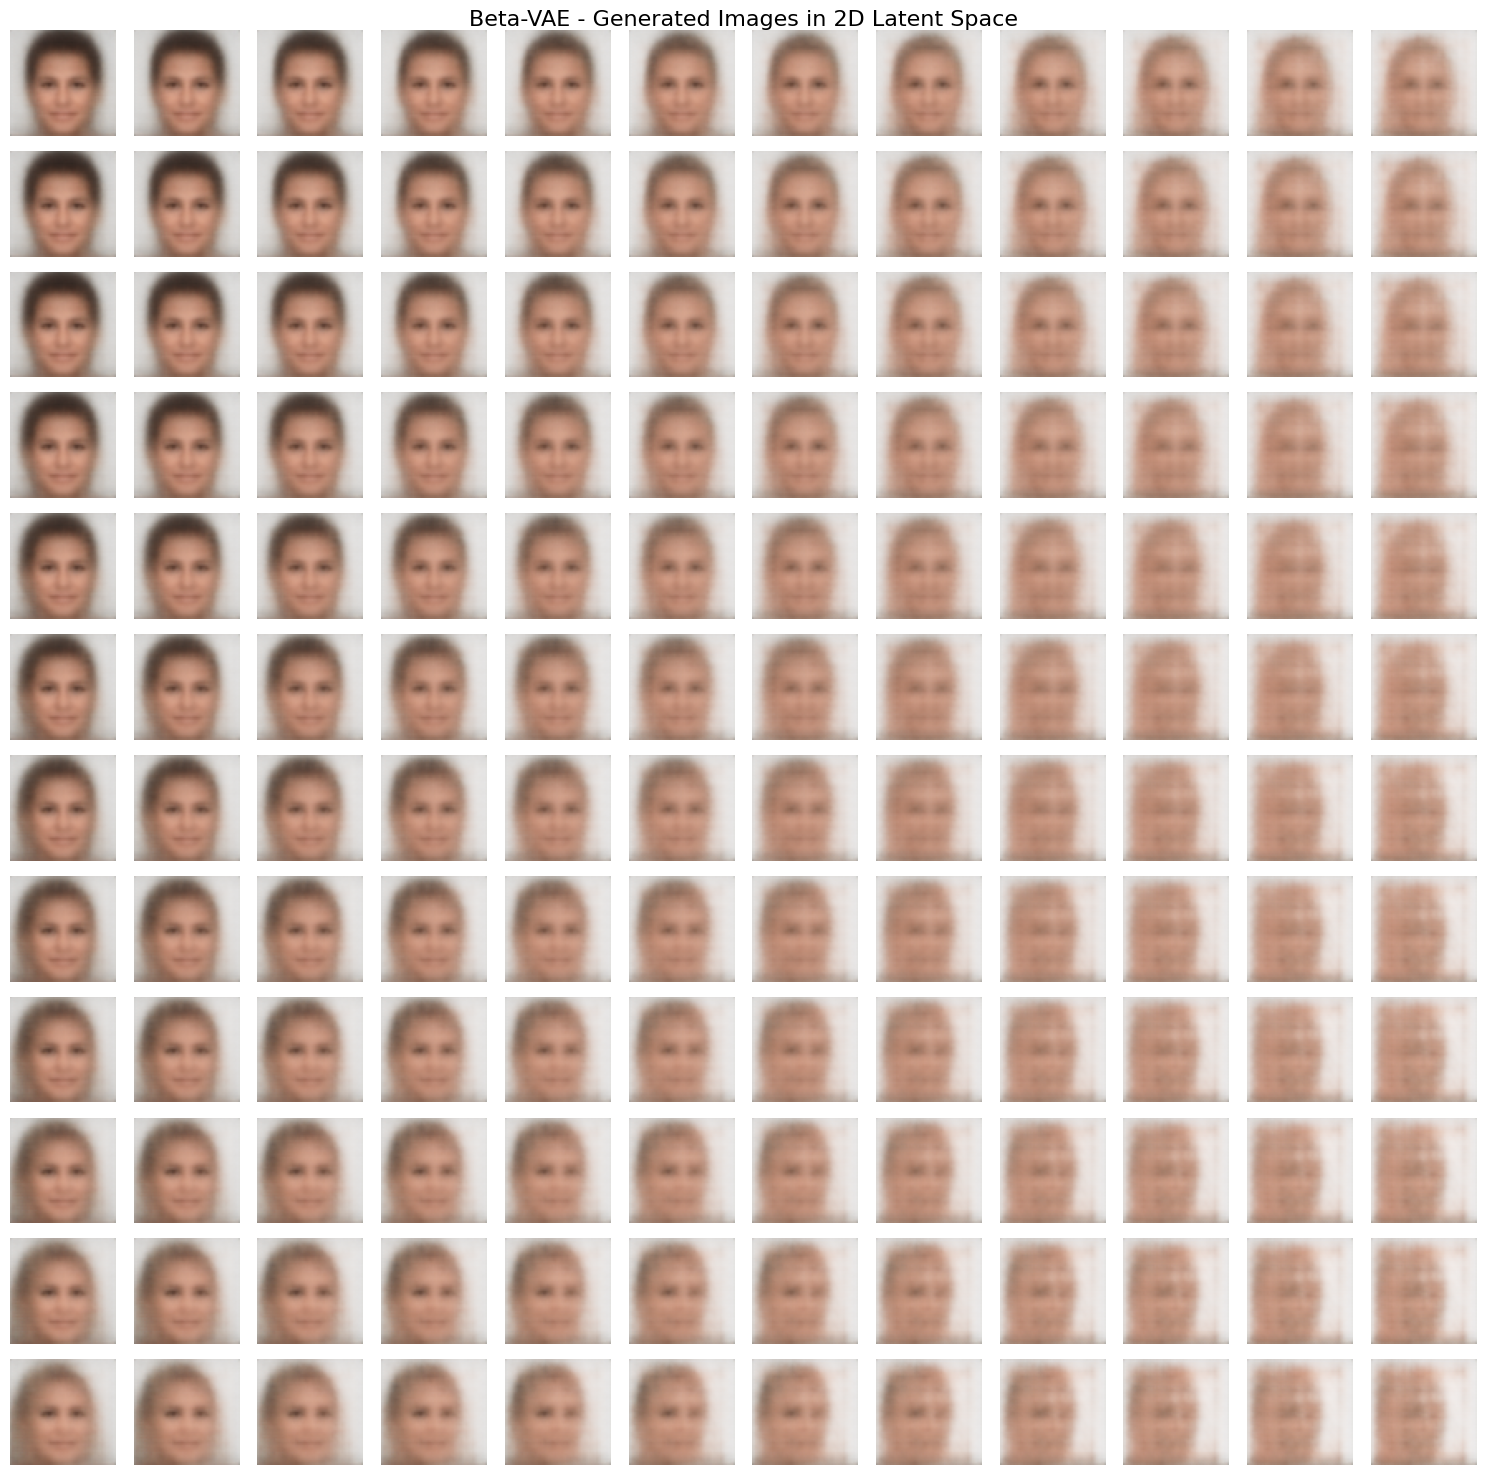


Beta = 4


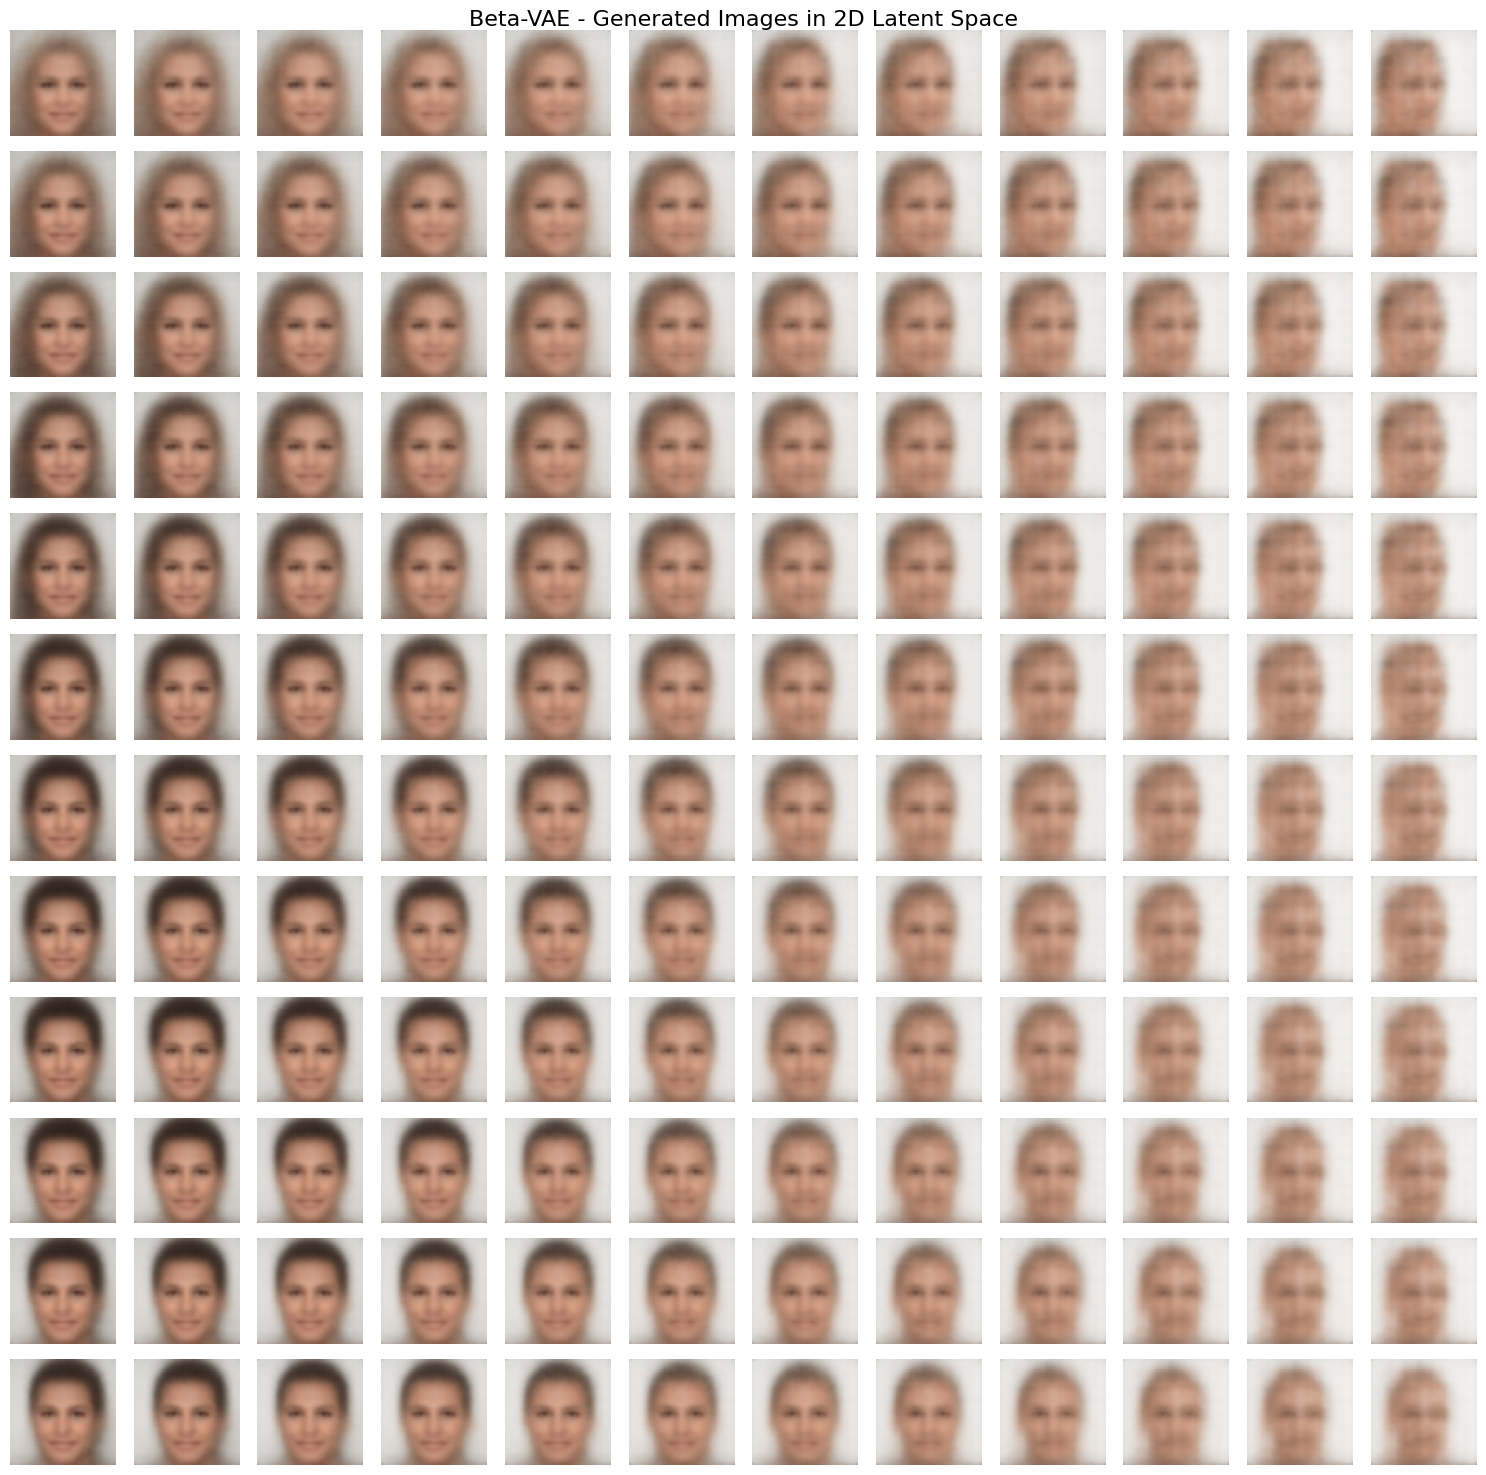


Beta = 10


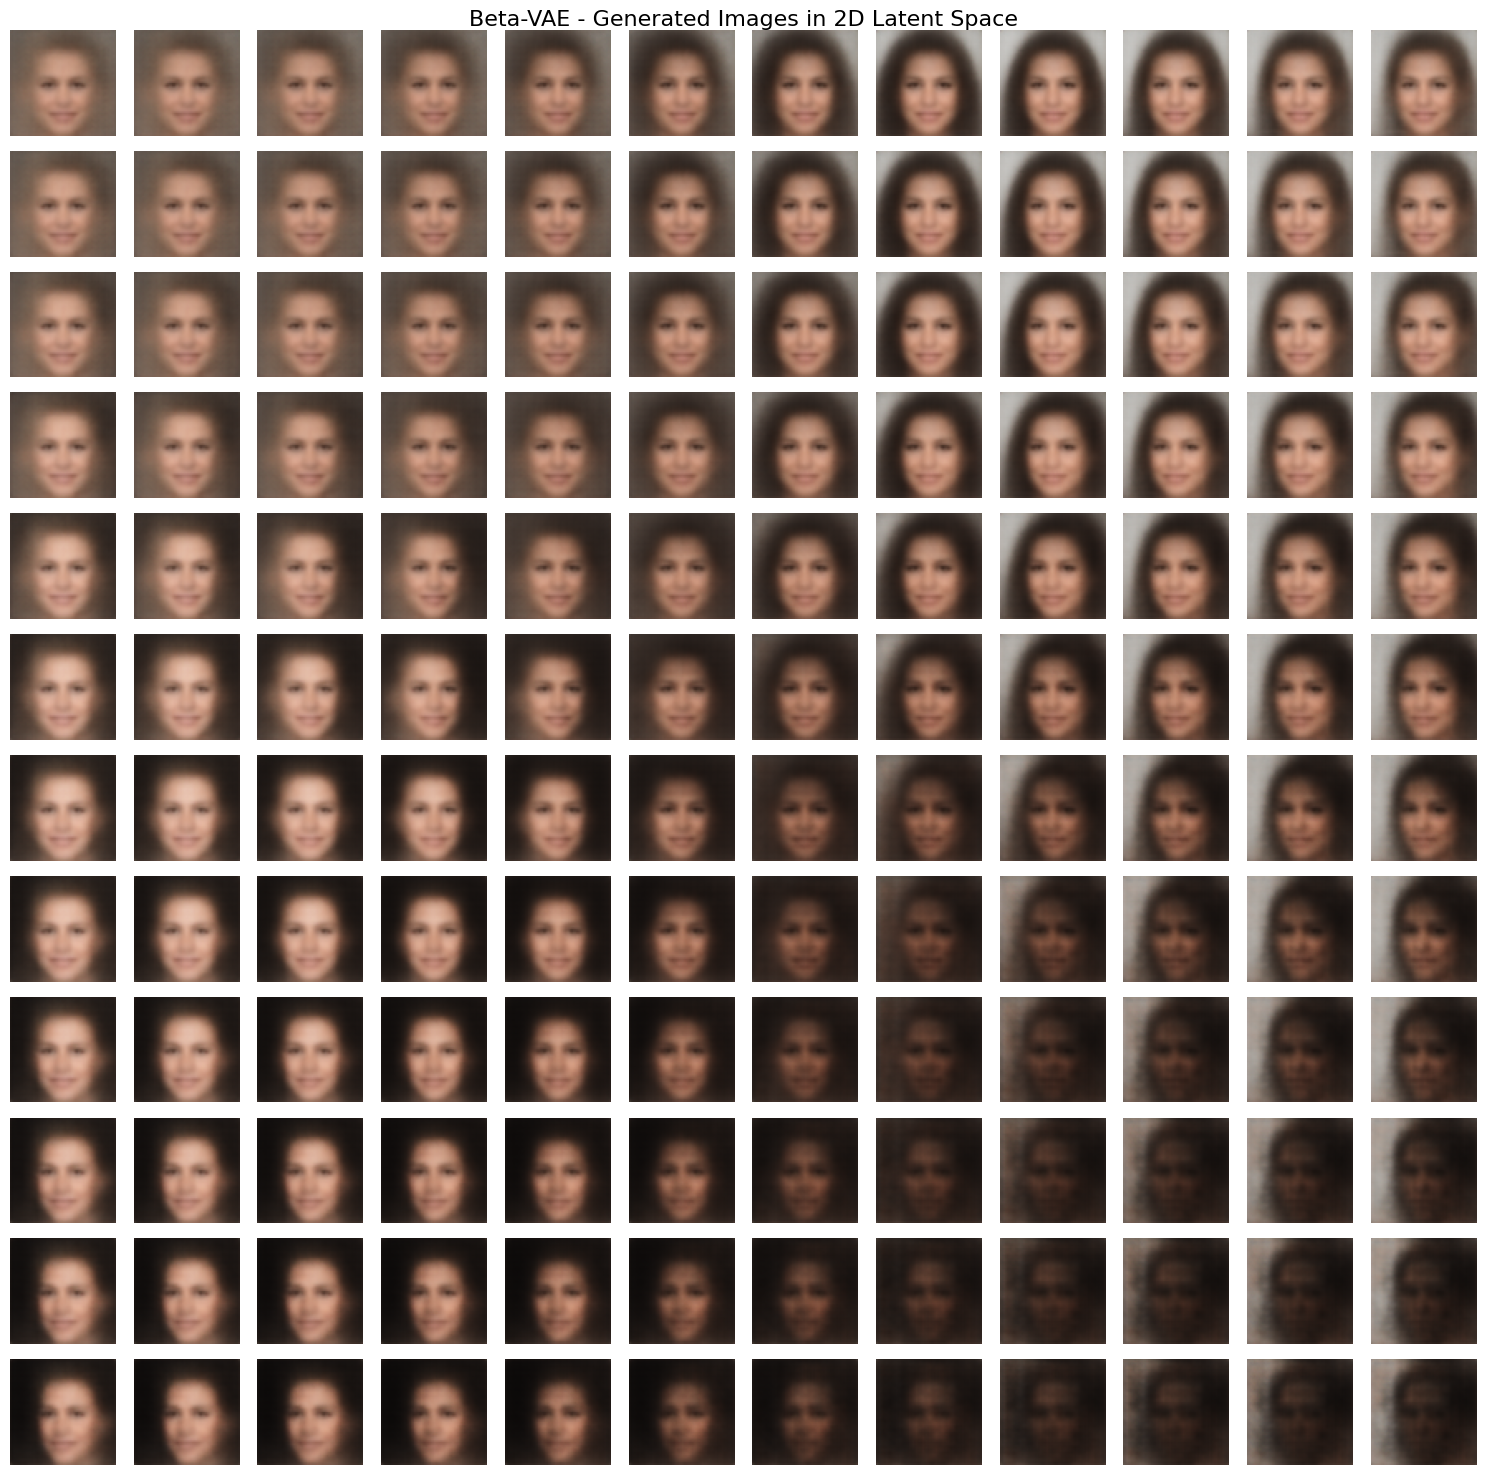

In [10]:
def visualize_model_outputs(trained_models, test_loader, device, num_images=4):
    """
    Display reconstructions and latent space visualizations for different beta values.

    Parameters
    ----------
        - trained_models (dict): Dictionary of trained models keyed by beta value.
        - test_loader (DataLoader): DataLoader for test set examples.
        - device (torch.device): Computation device.
        - num_images (int): Number of images to display.

    Returns
    -------
        - None, shows reconstructions and latent spaces.
    """
    print("-----------------------------------------------------------------------------------------------")
    print("Comparing Reconstructions for Different Beta Values:")
    print("-----------------------------------------------------------------------------------------------")
    for beta, results in trained_models.items():
        print(f"\nBeta = {beta}")
        visualize_reconstructions(results['model'], test_loader, device, num_images=num_images)

    print("-----------------------------------------------------------------------------------------------")
    print("Comparing Latent Space Visualizations:")
    print("-----------------------------------------------------------------------------------------------")
    for beta, results in trained_models.items():
        print(f"\nBeta = {beta}")
        generate_latent_space_visualization(results['model'], device)

visualize_model_outputs(trained_models, test_loader, device, num_images=4)

Comparing Reconstructions for Different Beta Values:
* β = 1: The reconstructions are noticeably blurry, but not too far off in terms of identity structure. This model focuses more on reconstruction fidelity but learns less disentangled or structured latent representations.
* β = 4: Reconstructions are still somewhat blurry, but sharper and more consistent than β = 1. You can see the reconstructed faces carry more texture and resemble the originals slightly better.
* β = 10: Reconstructions are the smoothest and most averaged of the three — they all look somewhat similar. Faces are overly generic in my personal opinion. 

Comparing Latent Space Visualizations:
* β = 1: Almost all generated faces look very similar, with minimal change across the grid. There is quite a bit of blurriness in the photos. 
* β = 4: Faces show more variation across the grid than β = 1. You can see subtle changes in features like head tilt, lighting, and facial expression. This seems better than β = 1.  
* β = 10: There is more variation in the latent space. Some generated images get darker or blurrier toward the corners. 

<div class="alert alert-block alert-warning"  style="background-color: #c78cf5; color: black;">  
  <h1>Conclusion</h1>
</div>

In this experiment, I trained and evaluated Beta-VAEs on the CelebA dataset using different values of the β hyperparameter (1, 4, and 10) to observe its effect on reconstruction quality and latent space structure.

Key Findings:
* **β = 1** behaves like a standard VAE, prioritizing reconstruction quality but producing a poorly disentangled latent space. Both the generated samples and reconstructions were more faithful in detail, but showed limited latent variation.
* **β = 4** offered the best balance between reconstruction accuracy and latent structure. It maintained visual quality while introducing meaningful, smooth variation across latent traversals.
* **β = 10** led to stronger disentanglement and a more regular latent space but at the cost of blurrier, more average-looking reconstructions. Traversals were structured but lacked diversity near the edges of the grid.

Visualizations and loss plots confirmed this trade-off:
* Increasing β reduced KL divergence and test loss.
* Reconstruction loss increased slightly with higher β, as the model was more constrained in how it encoded features.

Challenges & How I Addressed Them
* **Long compute time**: Training multiple models across 15 epochs with large image data was time-intensive. To mitigate this, I first tested my code on small dataset subsets to ensure everything ran correctly before full-scale training.
* **Balancing losses**: It was tricky to choose a β value that didn’t lead to overly generic reconstructions. Plotting the individual loss components (reconstruction and KL divergence) helped me analyze this trade-off more clearly.
* **Visual debugging**: Comparing reconstructions and latent traversals qualitatively helped validate whether the models were learning disentangled representations, beyond what metrics alone could show.
